# GMAC Optimization: Grid search of GMAC parameters

The GMAC algorithm has the following parameters required to map the raw acceleration
data to the arm-use space. These parameters are:
1. Moving average window size for pitch estimation. $\left( n_{p} \right)$
2. Butteworth highpass filter cut-off for accl. mag. estimation. $\left( f_{c} \right)$
3. Butteworth highpass filter order for accl. mag. estimation. $\left( n_{c} \right)$
4. Acceleration deadband threshold. $\left( a_{th0} \right)$
5. Moving average window for acceleration magnitude estimation. $\left( n_{am} \right)$
6. Pitch angle hysteresis lower threshold. $\left( \theta_{min} \right)$
7. Pitch angle hysteresis upper threshold. $\left( \theta_{max} \right)$
8. Acceleration magnitude hysteresis lower threshold. $\left( a_{min} \right)$
9.  Acceleration magnitude hysteresis upper threshold. $\left( a_{max} \right)$

## GMAC Algorithm

The GMAC algorithm is a combination of the gross movement (GM) algorithm and the 
activty counting (AC) algorithm. The GMAC algorithm, using only the accelerometer, 
tries to: (1) estimate the information used by GM and AC, forearm pitch angle and 
activity counts, respectively; and (2) applies thresholds on the estimated pitch 
and activity counting to estimate of the arm-use.

### Pitch Estimation
Pitch estimation is using the accelerometer data, and requies one to know the axis 
of accelerometer that is aligned with the forearm. The pitch is then estimated by 
estimating the arc-cosine of component of acceleration along this direction normalised 
by the magnitude of the acceleration due to gravity.

### Activity Counting Estimation
The activity counts is likely to be correlated to the magnitude of the highpass 
filtered acceleration.

### Applying thresholds
The pitch and activity counts are then thresholded to estimate the arm-use. 
Instead of applying a simple threshold algorithm that can be very sensitive to 
noise whenn the variable is close to the threshold, a thresholding procedure with 
hysteresis algorithm is used for both the pitch and the acceleration magnitude 
variables.

### Parameter search ranges
$F_s$ is the sampling frequency of the accelerometer data.
1. $n_{p} \in \left\{1, F_s/2, F_s, 2F_s, 5F_s\right\}$
2. $f_{c} \in [0.01, 0.1, 1]Hz \subset \mathbb{R}$
3. $n_{c} \in \left\{ 2, 4, 8\right\}$
4. $n_{am} \in \left\{1, F_s/2, F_s, 2F_s, 5F_s\right\}$
5. $a_{th0} \in \left\{ 0, 0.068, 0.68\right\}$
6. $\theta_{min}, \theta_{max} \in \left\{ 0, 20, \ldots +180 \right\}\deg$
7. $a_{min}, a_{max} \in \left\{0, 5, 10, 50, 100\right\}$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [14]:
import seaborn as sns

### Custom Modules

In [15]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

## Define notebook level constants

In [16]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [17]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

### Functions implementing the GMAC algorithm

In [18]:
def estimate_pitch(accl_farm: np.array, nwin: int) -> np.array:
    """
    Estimates the pitch angle of the forearm from the accelerometer data.
    """
    # Moving averaging using the causal filter
    acclf = signal.lfilter(np.ones(nwin) / nwin, 1, accl_farm) if nwin > 1 else accl_farm
    acclf[acclf < -1] = -1
    acclf[acclf > 1] = 1        
    return -np.rad2deg(np.arccos(acclf)) + 90


def estimate_accl_mag(accl: np.array, fs: float, fc: float, nc: int,
                      deadband_th: float, n_am: int) -> np.array:
    """
    Compute the magnitude of the accelerometer signal.
    """
    # Highpass filter the acceleration data.
    sos = signal.butter(nc, fc, btype='highpass', fs=fs, output='sos')
    accl_filt = np.array([signal.sosfilt(sos, accl[:, 0]),
                          signal.sosfilt(sos, accl[:, 1]),
                          signal.sosfilt(sos, accl[:, 2])]).T
    
    # Zero load acceleration components.
    accl_filt[np.abs(accl_filt) < deadband_th] = 0
    
    # Acceleration magnitude    
    amag = np.linalg.norm(accl_filt, axis=1)
    
    # Moving average filter
    _input = np.append(np.ones(n_am - 1) * amag[0], amag)
    _impresp = np.ones(n_am) / n_am
    return np.convolve(_input, _impresp, mode='valid')

In [19]:
def estimation_param_combinations(param_ranges: dict) -> tuple:
    """
    Generate the list of parameter combinations for estimating the pitch and 
    acceleration magnitude.
    """
    # Pitch and accl. mag. estimation parameters
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _ath in param_ranges["deadband_th"]:
                    for _nam in param_ranges["nam"]:
                        yield (_np, _fc, _nc, _ath, _nam)


# Generate all possible combinations of parameters.
def generate_param_combinations(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _estparams in estimation_param_combinations(param_ranges):
        for i1, _pmax in enumerate(param_ranges["p_th"]):
            for _pmin in param_ranges["p_th"][:i1+1]:
                for i2, _amax in enumerate(param_ranges["am_th"]):
                    for _amin in param_ranges["am_th"][:i2+1]:
                        yield {
                            "np": int(_estparams[0]),
                            "fc": _estparams[1],
                            "nc": int(_estparams[2]),
                            "deadband_th": _estparams[3],
                            "nam": int(_estparams[4]),
                            "p_thmin": _pmin,
                            "p_thmax": _pmax,
                            "am_thmin": _amin,
                            "am_thmax": _amax
                        }

In [20]:
def apply_threshold_with_hysteresis(data: np.array, thmin: float, thmax: float,
                                    out0: float=0):
    """
    Applies threshold to the given data using the thmin and thmax thresholds.
    """
    _out = np.zeros(len(data))
    _out[0] = out0
    for i in range(1, len(_out)):
        if _out[i - 1] == 0:
            _out[i] = 1 if data[i] >= thmax else 0
        else:
            _out[i] = 0 if data[i] < thmin else 1
    return _out

In [21]:
def estimate_gmac(accl: np.array, accl_farm_inx: int, Fs: float, params: dict) -> np.array:
    """
    Estimate GMAC for the given acceleration data and parameters.
    """
    # Estimate pitch and acceleration magnitude
    pitch = estimate_pitch(accl[:, accl_farm_inx], params["np"])
    accl_mag = estimate_accl_mag(accl, Fs, fc=params["fc"], nc=params["nc"],
                                 deadband_th=params["deadband_th"],
                                 n_am=params["nam"])
    
    # Compute GMAC
    _pout = apply_threshold_with_hysteresis(pitch, params["p_thmin"], params["p_thmax"])
    _amout = apply_threshold_with_hysteresis(accl_mag, params["am_thmin"], params["am_thmax"])
    return _pout * _amout

In [22]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

#### Parameter ranges for the grid search

In [23]:
outdir = "../data/output"
limbkey = "unaff"
# Make directory if it does not exist
pathlib.Path(outdir, limbkey).mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
gmac_param_ranges = {
    "np": [1, Fs, 5*Fs],
    "fc": [0.01, 0.1, 1],
    "nc": [2, 4],
    "deadband_th": [0, 0.068, 0.68],
    "nam": [1, Fs, 5*Fs],
    "p_th": np.arange(-90, 90, 30),
    "am_th": [0, 1, 5, 10]
}

# Number of all possible combinations
Ncombs = len(list(generate_param_combinations(gmac_param_ranges)))

# All parameter combinations.
param_combs = list(generate_param_combinations(gmac_param_ranges))


In [ ]:
# Which limb?
limbdf = datadf[limbkey]
subjects = limbdf.subject.unique()

# All param combinations.
init_df = lambda : pd.DataFrame(columns=["subject", "pcinx",
                                   "np", "fc", "nc", "deadband_th", "nam",
                                   "p_thmin", "p_thmax",
                                   "am_thmin", "am_thmax",
                                   "TN", "FP", "FN", "TP"])
analysisdf = init_df()

nrows_write = 1000

# Check if any files exist
_files = glob.glob(pathlib.Path(outdir, limbkey, f"analysisdf-*.csv").as_posix())
if len(_files) == 0:
    nrow_max = 0
else:
    nrow_max = np.max([int(_f.split(".csv")[0].split("-")[-1])
                    for _f in _files])
# Written file name
_wrtnfile = ''
_wrtnrows = 0
for i1, _pc in enumerate(generate_param_combinations(gmac_param_ranges)):
    # Check if data already exists
    if i1 // nrows_write < nrow_max:
        continue
    # All subjects
    for i2, _subj in enumerate(subjects):
        _sinx= limbdf.subject == _subj
        # All segments
        segs = limbdf[_sinx].segment.unique()
        _gmacs = []
        for i3, _seg in enumerate(segs):
            sys.stdout.write(f"\r[{limbkey}] [Wrote: ({_wrtnfile})({_wrtnrows})] Combination: {i1+1:8d}/{Ncombs:6d}; {i2+1:3d}/{len(subjects):3d}; {i3+1:2d}/{len(segs):2d}")
            sys.stdout.flush()
            _ainx = _sinx & (limbdf.segment == _seg)
            # Estimate GMAC
            _accl = limbdf.loc[_ainx, ['ax', 'ay', 'az']].values
            _gmacs.append(estimate_gmac(_accl, 0, Fs, _pc))
        
        # Estimate confusion matrix components
        _perf = compute_confusion_matrix(actual=limbdf.loc[_sinx, "gnd"].values,
                                         estimated=np.hstack(_gmacs))
        # Update analysis DF
        _rowdf = pd.DataFrame({"subject": _subj, "pcinx": i1} | _pc | _perf, index=[0])
        analysisdf = pd.concat([analysisdf,_rowdf],
                               axis=0, ignore_index=True)
    # Save data regularly
    if i1 > 0 and i1 % nrows_write == 0:
        _wrtnfile = f"analysisdf-{(i1 // nrows_write) - 1}.csv"
        _wrtnrows = len(analysisdf)
        analysisdf.to_csv(pathlib.Path(outdir, limbkey, _wrtnfile).as_posix(), index=False)
        analysisdf = init_df()

# Save whatever is left
_wrtnfile = f"analysisdf-{(i1 // nrows_write)}.csv"
_wrtnrows = len(analysisdf)
sys.stdout.write(f"\r[{limbkey}] [Wrote: ({_wrtnfile})({_wrtnrows})] Combination: {i1+1:8d}/{Ncombs:6d}; {i2+1:3d}/{len(subjects):3d}; {i3+1:2d}/{len(segs):2d}")
analysisdf.to_csv(pathlib.Path(outdir, limbkey, f"analysisdf-{(i1 // nrows_write)}.csv"), index=False)

## Find the most appropriate paramters

In [29]:
def performance(yjvals: np.array) -> dict:
    """
    Computes the performance of the given GMAC.
    """
    if len(yjvals) == 0:
        return {
            "median": np.nan,
            "q5": np.nan,
            "q95": np.nan,
            "s90": np.nan,
            "perf": np.nan
        }
    q5, q50, q95 = np.percentile(yjvals, q=[5, 50, 95])
    return {
        "median": q50,
        "q5": q5,
        "q95": q95,
        "s90": q95 - q5,
        "perf": np.abs(q50 - 1) + 0.5 * (q95 - q5)
    }

In [81]:
limbkey = "left"
# Read all data and combine into a sigle DF
files = glob.glob(pathlib.Path(outdir, limbkey, "analysisdf*.csv").as_posix())
allanalysisdf = pd.read_csv(files[0], index_col=False)
for _f in files[1:]:
    _df = pd.read_csv(_f, index_col=False)
    allanalysisdf = pd.concat([allanalysisdf, _df], axis=0, ignore_index=True)
allanalysisdf

,subject,pcinx,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,TN,FP,FN,TP
0,2,6001,1,0.10,4,0.000,50,-30,30,0,1,7049,80,15878,1255
1,3,6001,1,0.10,4,0.000,50,-30,30,0,1,4902,4125,5006,8142
2,4,6001,1,0.10,4,0.000,50,-30,30,0,1,5210,2669,6776,7069
3,5,6001,1,0.10,4,0.000,50,-30,30,0,1,4605,3466,5838,6371
4,6,6001,1,0.10,4,0.000,50,-30,30,0,1,7551,1715,10608,6654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340195,7,12000,50,0.01,2,0.068,1,-90,-30,0,0,3,9268,1,14234
340196,8,12000,50,0.01,2,0.068,1,-90,-30,0,0,2,7967,0,19449
340197,9,12000,50,0.01,2,0.068,1,-90,-30,0,0,3,21155,0,16160
340198,10,12000,50,0.01,2,0.068,1,-90,-30,0,0,3,8690,1,13573


In [82]:
# Compute different performance metrics
# Sensitivity
allanalysisdf["sensitivity"] = allanalysisdf.TP / (allanalysisdf.TP + allanalysisdf.FN)
# Specificity
allanalysisdf["specificity"] = allanalysisdf.TN / (allanalysisdf.TN + allanalysisdf.FP)
# Youden's J
allanalysisdf["youden"] = allanalysisdf.sensitivity + allanalysisdf.specificity - 1

# Save analysis DF
allanalysisdf.to_csv(pathlib.Path(outdir, limbkey, "allanalysisdf.csv"), index=False)

In [30]:
# Subjects
subjs = np.sort(allanalysisdf.subject.unique())
q = 95

# Optimization data frame
optdf = pd.DataFrame(columns=["pcinx", "median", "q95", "q5", "s90", "cost", "testval", "testsubj"])
for _nc in range(Ncombs):
    for sinx in range(len(subjs)):
        sys.stdout.write(f"\rCombination: {_nc+1:8d}/{Ncombs:6d}; {sinx+1:3d}/{len(subjs):3d}")
        sys.stdout.flush()
        testsubj = subjs[sinx]
        trainsubj = subjs[~(subjs == testsubj)]
        
        # Find the best parameter combination for the training subjects.
        _subjtraininx = allanalysisdf.subject.isin(trainsubj)
        _subjtestinx = allanalysisdf.subject == testsubj
        _inxtrain = allanalysisdf.pcinx == _nc
        _inxtest = allanalysisdf.pcinx == _nc
        
        # Find the best parameter combination for the training subjects.
        _yitrain = allanalysisdf.loc[_subjtraininx & _inxtrain, "youden"]
        _yitest = allanalysisdf.loc[_subjtestinx & _inxtest, "youden"]
        
        # Performance vairables.
        _perf = performance(_yitrain.values)
        _perfdf = pd.DataFrame({
            "pcinx": _nc,
            "median": _perf["median"],
            "q95": _perf["q95"],
            "q5": _perf["q5"],
            "s90": _perf["s90"],
            "cost": _perf["perf"],
            "testval": _yitest.values,
            "testsubj": testsubj
        })
        optdf = pd.concat([optdf, _perfdf], ignore_index=True)

# Save the optimization data frame        
optdf.to_csv(pathlib.Path(outdir, limbkey, f"optdf.csv"), index=False)

Combination:    34020/ 34020;  10/ 10

In [88]:
optdf = pd.read_csv(pathlib.Path(outdir, limbkey, f"optdf.csv"), index_col=False)

# Go through each validation subject, and choose the best training cost 
# parameter combination.
bestparamsdf = pd.DataFrame(columns=["subj", "lbound", "bestpinx", "bestval"])
for _subj in optdf.testsubj.unique():
    # _minval = np.min(optdf.loc[optdf.testsubj == _subj, "cost"])
    _sinx = optdf.testsubj == _subj
    _lbound = np.percentile(optdf.loc[optdf.testsubj == _subj, "cost"], 1)
    _bpins = list(np.where(optdf.loc[_sinx, "cost"] <= _lbound)[0])
    _bval = list(optdf.loc[_sinx, "testval"].values[_bpins])
    bestparamsdf = pd.concat([bestparamsdf, 
                              pd.DataFrame({"subj": [_subj] * len(_bpins),
                                            "lbound": [_lbound] * len(_bpins),
                                            "bestpinx": _bpins,
                                            "bestval": _bval})],
                             ignore_index=True)
# Save the optimization data frame
bestparamsdf.to_csv(pathlib.Path(outdir, limbkey, f"bestparamsdf.csv"), index=False)

In [140]:
# Find out how often these parameters are chosen as the best parameter
# combination across different subjects.
allbestparams = bestparamsdf["bestpinx"].value_counts()
allbestparams = allbestparams.sort_index()

# Find indices of the best parameter combinations that are most common.
# i.e. they appear in atleast 80% of the subjects.
best_common_inx = allbestparams[allbestparams >= 1 * len(subjs)].index.values

best_common_inx

array([80, 81, 290, 500, 710, 711, 920, 1130, 1340, 1550, 1760, 1970,
       1971, 2180, 2181, 2390, 2600, 2601, 2810, 2811, 3020, 3230, 3440,
       3650, 3860, 3861, 4070, 4280, 4490, 4491, 4700, 4910, 5120, 5330,
       5540, 5750, 5751, 5960, 6170, 6380, 6381, 6590, 6800, 7010, 7220,
       7430, 7640, 7850, 8060, 8270, 8480, 8690, 8900, 9110, 9320, 9530,
       9740, 9950, 10160, 10370, 10580, 10790, 11000, 11210, 11420, 11421,
       11630, 11840, 12050, 12051, 12260, 12470, 12680, 12890, 13100,
       13310, 13311, 13520, 13521, 13730, 13940, 13941, 14150, 14151,
       14360, 14570, 14780, 14990, 15200, 15201, 15410, 15620, 15830,
       15831, 16040, 16250, 16460, 16670, 16880, 17090, 17091, 17300,
       17510, 17720, 17721, 17930, 18140, 18350, 18560, 18770, 18980,
       19190, 19400, 19610, 19820, 20030, 20240, 20450, 20660, 20870,
       21080, 21290, 21500, 21710, 21920, 22130, 22340, 22550, 22971,
       23601], dtype=object)

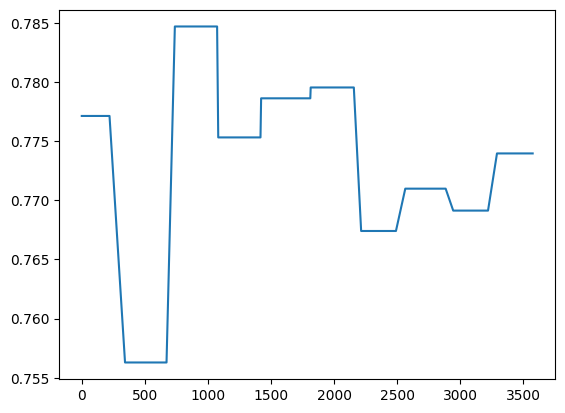

In [148]:
plt.plot(bestparamsdf.loc[bestparamsdf.bestpinx.isin(best_common_inx), 'lbound'])

In [149]:
bestparamsdf

,subj,lbound,bestpinx,bestval
0,1,0.777130,80,0.315372
1,1,0.777130,81,0.315372
2,1,0.777130,290,0.315372
3,1,0.777130,500,0.315372
4,1,0.777130,710,0.315372
...,...,...,...,...
3641,10,0.773963,33050,0.301329
3642,10,0.773963,33260,0.301329
3643,10,0.773963,33470,0.301329
3644,10,0.773963,33680,0.301329


In [141]:
# Dataframe of the best parameter combinations
best_pc_vals_df = pd.DataFrame.from_dict([param_combs[_inx] for _inx in best_common_inx])

# We need to look at each parameter differently.
# np
np_summ = best_pc_vals_df.np.value_counts()
# fc nad nc
fcnc_summ = best_pc_vals_df[["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts()
# deadband_th
dbth_summ = best_pc_vals_df.deadband_th.value_counts()
# nam
nam_summ = best_pc_vals_df.nam.value_counts()
# pth
pth_summ = best_pc_vals_df[["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts()
# amth
amth_summ = best_pc_vals_df[["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts()

# Print the summary
print(f"np: {np_summ}")
print(f"fcnc: {fcnc_summ}")
print(f"dbth: {dbth_summ}")
print(f"nam: {nam_summ}")
print(f"pth: {pth_summ}")
print(f"amth: {amth_summ}")

np: np
1      64
50     64
250     2
Name: count, dtype: int64
fcnc: 0.01:4.0    26
0.01:2.0    24
0.1:2.0     22
0.1:4.0     22
1.0:2.0     18
1.0:4.0     18
Name: count, dtype: int64
dbth: deadband_th
0.000    47
0.068    47
0.680    36
Name: count, dtype: int64
nam: nam
1      52
50     42
250    36
Name: count, dtype: int64
pth: -30:0    130
Name: count, dtype: int64
amth: 0:0    108
0:1     22
Name: count, dtype: int64


In [138]:
np_val = 1
fc_val = 0.1
nc_val = 2
deadband_th_val = 0
nam_val = 1
p_thmin_val = -30
p_thmax_val = 0
am_thmin_val = 0
am_thmax_val = 0

# Does this exist?
_vals = [np_val, fc_val, nc_val, deadband_th_val, nam_val,
         p_thmin_val, p_thmax_val, am_thmin_val, am_thmax_val]


In [139]:
np.sum(list(best_pc_vals_df.to_numpy()) == np.array(_vals), axis=1)

array([7, 6, 8, 7, 6, 7, 6, 7, 6, 5, 7, 6, 5, 6, 5, 6, 6, 7, 5, 6, 5, 6,
       6, 5, 7, 6, 5, 4, 4, 6, 5, 5, 6, 5, 4, 6, 5, 4, 3, 3, 5, 4, 4, 5,
       5, 6, 5, 4, 5, 4, 5, 8, 7, 9, 8, 7, 8, 7, 8, 7, 6, 8, 7, 6, 7, 6,
       7, 7, 8, 6, 7, 6, 7, 7, 8, 7, 6, 7, 6, 7, 6, 7, 6, 5, 6, 5, 6, 6,
       7, 5, 6, 5, 6, 7, 8, 6, 7, 6, 7, 6, 7, 5, 6, 5, 6, 6, 7, 5, 6, 5,
       6, 6, 7, 5, 6, 5, 6, 5, 6, 4, 5, 4, 5, 5, 6, 4, 5, 4, 5, 6, 5, 7,
       6, 5, 6, 5, 6, 5, 4, 6, 5, 4, 5, 4, 5, 5, 6, 4, 5, 4, 5, 5, 4, 6,
       5, 4, 5, 4, 4, 5, 4, 3, 5, 4, 3, 4, 3, 3, 4, 4, 5, 4, 3, 4, 3, 4,
       7, 6, 8, 7, 6, 7, 6, 7, 6, 5, 7, 6, 5, 6, 5, 6, 6, 7, 5, 6, 5, 6,
       6, 7, 6, 5, 6, 5, 6, 5, 6, 5, 4, 5, 4, 5, 5, 6, 4, 5, 4, 5, 6, 7,
       5, 6, 5, 6, 5, 6, 4, 5, 4, 5, 5, 6, 4, 5, 4, 5, 5, 6, 4, 5, 4, 5,
       4, 5, 3, 4, 3, 4, 4, 5, 3, 4, 3, 4, 5, 4])

In [137]:
np.sum(list(best_pc_vals_df.to_numpy()) == best_pc_vals_df.to_numpy()[0, :], axis=1)

array([9, 8, 8, 7, 8, 7, 8, 7, 8, 7, 7, 6, 7, 6, 7, 6, 8, 7, 7, 6, 7, 6,
       8, 7, 7, 6, 7, 6, 4, 6, 5, 7, 6, 7, 6, 6, 5, 6, 5, 3, 5, 4, 6, 5,
       7, 6, 5, 6, 5, 6, 5, 8, 7, 7, 6, 7, 6, 7, 6, 7, 6, 6, 5, 6, 5, 6,
       5, 7, 6, 6, 5, 6, 5, 7, 6, 5, 6, 5, 6, 5, 6, 5, 4, 5, 4, 5, 4, 6,
       5, 5, 4, 5, 4, 8, 7, 7, 6, 7, 6, 7, 6, 6, 5, 6, 5, 7, 6, 6, 5, 6,
       5, 7, 6, 6, 5, 6, 5, 6, 5, 5, 4, 5, 4, 6, 5, 5, 4, 5, 4, 8, 7, 7,
       6, 7, 6, 7, 6, 7, 6, 6, 5, 6, 5, 6, 5, 7, 6, 6, 5, 6, 5, 7, 6, 6,
       5, 6, 5, 4, 6, 5, 6, 5, 5, 4, 5, 4, 3, 5, 4, 6, 5, 4, 5, 4, 5, 4,
       7, 6, 6, 5, 6, 5, 6, 5, 6, 5, 5, 4, 5, 4, 5, 4, 6, 5, 5, 4, 5, 4,
       6, 5, 4, 5, 4, 5, 4, 5, 4, 3, 4, 3, 4, 3, 5, 4, 4, 3, 4, 3, 7, 6,
       6, 5, 6, 5, 6, 5, 5, 4, 5, 4, 6, 5, 5, 4, 5, 4, 6, 5, 5, 4, 5, 4,
       5, 4, 4, 3, 4, 3, 5, 4, 4, 3, 4, 3, 5, 4])

In [120]:
bpcvals = best_pc_vals_df.to_numpy()
best_pc_vals_df

,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax
0,1,0.01,2,0.000,1,-30,-30,0,0
1,1,0.01,2,0.000,1,-30,-30,0,1
2,1,0.01,2,0.000,1,-30,0,0,0
3,1,0.01,2,0.000,1,-30,0,0,1
4,1,0.01,2,0.000,50,-30,-30,0,0
...,...,...,...,...,...,...,...,...,...
251,50,1.00,4,0.680,50,-30,0,0,0
252,50,1.00,4,0.680,250,-30,-30,0,0
253,50,1.00,4,0.680,250,-30,0,0,0
254,250,0.01,2,0.000,50,-30,0,0,1


In [116]:
def get_param_comb_difference(x1: np.array, x2: np.array) -> np.array:
    """Returns a custom distanc measure between two parameter combinations.
    """
    inx_cols = ["np", "fc", "nc", "deadband_th", "nam",
                "p_th", "p_th", "am_th", "am_th"]
    get_diff = lambda x, y, col: (np.where(gmac_param_ranges[col] == x)[0][0] -
                                np.where(gmac_param_ranges[col] == y)[0][0])
    return np.linalg.norm([get_diff(*v) for v in zip(x1, x2, inx_cols)], ord=1)

In [118]:
get_param_comb_difference(bpcvals[0, :], bpcvals[23, :])



2.0

In [111]:
d1 = np.zeros(len(x1))
d1[0] = get_diff(x1[0], x2[0], "np")
d1[1] = get_diff(x1[1], x2[1], "fc")
d1[2] = get_diff(x1[2], x2[2], "nc")
d1[3] = get_diff(x1[3], x2[3], "deadband_th")
d1[4] = get_diff(x1[4], x2[4], "nam")
d1[5] = get_diff(x1[5], x2[5], "p_th")
d1[6] = get_diff(x1[6], x2[6], "p_th")
d1[7] = get_diff(x1[7], x2[7], "am_th")
d1[8] = get_diff(x1[8], x2[8], "am_th")
d1

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])

In [104]:
gmac_param_ranges

{'np': [1, 50, 250],
 'fc': [0.01, 0.1, 1],
 'nc': [2, 4],
 'deadband_th': [0, 0.068, 0.68],
 'nam': [1, 50, 250],
 'p_th': array([-90, -60, -30,   0,  30,  60]),
 'am_th': [0, 1, 5, 10]}

In [34]:
# Best parameters count
bp_val_count = {_c: 100 * best_pc_vals_df[_c].value_counts() / len(best_pc_vals_df)
                for _c in best_pc_vals_df.columns}

# Write this to a file
_fname = pathlib.Path(outdir, limbkey, "best_param_combs.txt")
with open(_fname, "w") as fh:
    # Write header
    fh.write(f"Best parameter combinations for {limbkey}:\n")
    for k, v in bp_val_count.items():
        fh.write(f"\n{k}: {v}\n")

In [35]:
# np value
np_val = 1
p_thmin_val = -30
p_thmax_val = 0
am_thmin_val = 0
am_thmax_val = 0
new_bp_df = best_pc_vals_df.loc[(best_pc_vals_df.np == np_val) &
                                (best_pc_vals_df.p_thmin == p_thmin_val) &
                                (best_pc_vals_df.p_thmax == p_thmax_val) &
                                (best_pc_vals_df.am_thmin == am_thmin_val) &
                                (best_pc_vals_df.am_thmax == am_thmax_val), :].copy()
new_bp_df.reset_index(drop=True, inplace=True)
new_bp_df

,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax


In [36]:
_fc_vals, _nc_vals = (np.unique(new_bp_df["fc"].values),
                      np.unique(new_bp_df["nc"].values))
_fcnc_combs = list(itertools.product(_fc_vals, _nc_vals))
# Count of the different fc and nc combinations
_fcnc_combs_count = {
    (_fc, _nc): len(new_bp_df.loc[(new_bp_df["fc"] == _fc) &
                                  (new_bp_df["nc"] == _nc), :])
    for _fc, _nc in _fcnc_combs
}
print(_fcnc_combs_count)

_fname = pathlib.Path(outdir, limbkey, "best_param_combs.txt")
with open(_fname, "a") as fh:
    # Write header
    fh.write(f"\n--- fc, nc Combinations ---\n")
    for k, v in _fcnc_combs_count.items():
        fh.write(f"\n{k}: {v}\n")

{}


In [37]:
_nam_vals, _db_vals = (np.unique(new_bp_df["nam"].values),
                       np.unique(new_bp_df["deadband_th"].values))
_nmdb_combs = list(itertools.product(_nam_vals, _db_vals))
# Count of the different fc and nc combinations
_nmdb_combs_counts = {
    (_nam, _db): len(new_bp_df.loc[(new_bp_df["nam"] == _nam) &
                                  (new_bp_df["deadband_th"] == _db), :])
    for _nam, _db in _nmdb_combs
}
print(_nmdb_combs_counts)

_fname = pathlib.Path(outdir, limbkey, "best_param_combs.txt")
with open(_fname, "a") as fh:
    # Write header
    fh.write(f"\n--- nam, deadband_th Combinations ---\n")
    for k, v in _nmdb_combs_counts.items():
        fh.write(f"\n{k}: {v}\n")

{}


In [121]:
limbkey

'left'